## HEATMAPS

We test the first total_epochs


Each epoch is calculated by binning time_epoch time


All hosts in this time frame are taken into account

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

time_epoch = 60
total_epochs = 10

# hard coded nrows
df_all = pd.read_csv('../../../diploma/multi-source-syber-security-events/flows.txt', header=None, nrows=120000)

df_all.columns = ['time', 'duration', 'source computer', 'source port', 'destination computer', 
              'destination port', 'protocol', 'packet count', 'byte count']

df_all = df_all[df_all['time'] <= time_epoch * total_epochs]
df_all.index = df_all['time']
df_all.drop(columns=['time'],inplace=True)

In [2]:
# get all the host in the buckets we are interested in 

hosts = np.array(list(set(df_all['source computer'].values))) 

print('Testing a total of', len(hosts), 'hosts')

Testing a total of 1435 hosts


# First we will train on the whole dataset 
# TODO addZeros=True

# Ruins the distribution for now

In [3]:
from helper import group_scale_data, group_scale_data_batch

groupped_data, hosts, parameters = group_scale_data(df_all, size_of_bin_seconds=time_epoch,
                                                    doScale=True, addZeros=True, scaler='log', hosts=hosts, verbose=1)

A total of 10 time epochs have been encountered
Done with 0 hosts out of 1435
Done with 71 hosts out of 1435
Done with 142 hosts out of 1435
Done with 213 hosts out of 1435
Done with 284 hosts out of 1435
Done with 355 hosts out of 1435
Done with 426 hosts out of 1435
Done with 497 hosts out of 1435
Done with 568 hosts out of 1435
Done with 639 hosts out of 1435
Done with 710 hosts out of 1435
Done with 781 hosts out of 1435
Done with 852 hosts out of 1435
Done with 923 hosts out of 1435
Done with 994 hosts out of 1435
Done with 1065 hosts out of 1435
Done with 1136 hosts out of 1435
Done with 1207 hosts out of 1435
Done with 1278 hosts out of 1435
Done with 1349 hosts out of 1435
Done with 1420 hosts out of 1435
Scaeling...


In [4]:
from emClustering import OnlineEM
from plots import plot_points, plot_results, plot_category, plot_all_categories
from kplusplus import KPlusPlus

In [5]:
mixtures = 20

kplusplus = KPlusPlus(mixtures, groupped_data.values[:, :2], stochastic=True, stochastic_n_samples=3000)

kplusplus.init_centers(verbose=1)

# random initialization
onlineEM = OnlineEM([1/mixtures]*mixtures, kplusplus.centers, 500, n_clusters=8, verbose=1)

Centers found: 1
Centers found: 2
Centers found: 3
Centers found: 4
Centers found: 5
Centers found: 6
Centers found: 7
Centers found: 8
Centers found: 9
Centers found: 10
Centers found: 11
Centers found: 12
Centers found: 13
Centers found: 14
Centers found: 15
Centers found: 16
Centers found: 17
Centers found: 18
Centers found: 19


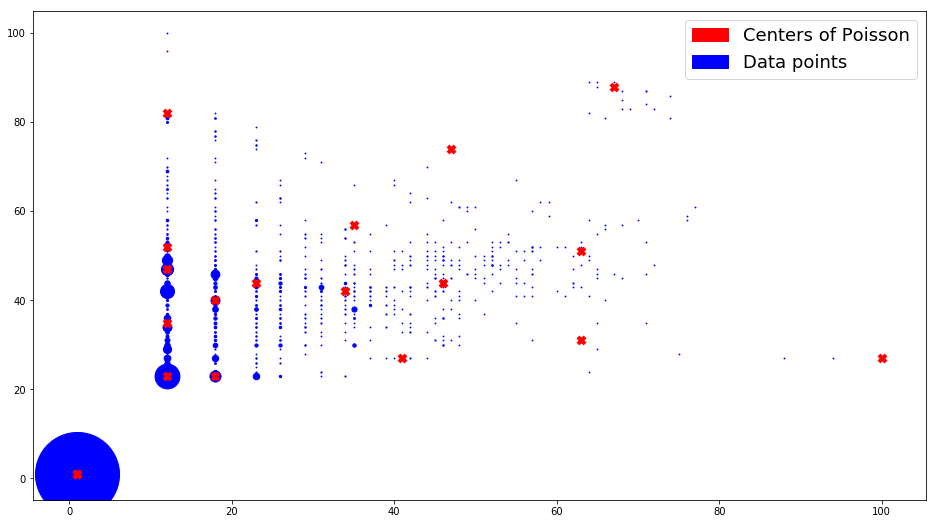

In [6]:
plot_points(groupped_data.values[:, :2], onlineEM)

In [7]:
# ignore epoch index for now

data = groupped_data.values[:,[0,1,3]]

np.random.shuffle(data)


onlineEM.fit(data)

Running for data till position 500 from total 14350
Running for data till position 1000 from total 14350
Running for data till position 1500 from total 14350
Running for data till position 2000 from total 14350
Running for data till position 2500 from total 14350
Running for data till position 3000 from total 14350
Running for data till position 3500 from total 14350
Running for data till position 4000 from total 14350
Running for data till position 4500 from total 14350
Running for data till position 5000 from total 14350
Running for data till position 5500 from total 14350
Running for data till position 6000 from total 14350
Running for data till position 6500 from total 14350
Running for data till position 7000 from total 14350
Running for data till position 7500 from total 14350
Running for data till position 8000 from total 14350
Running for data till position 8500 from total 14350
Running for data till position 9000 from total 14350
Running for data till position 9500 from total 

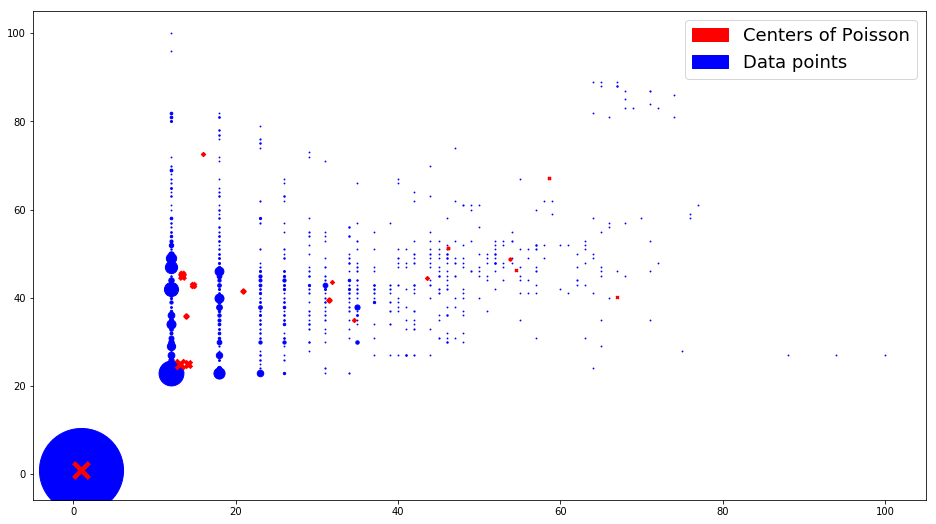

In [8]:
plot_points(groupped_data.values[:, :2], onlineEM)

### First we shall explore how the average values shift between different hosts and different epochs in our dataset

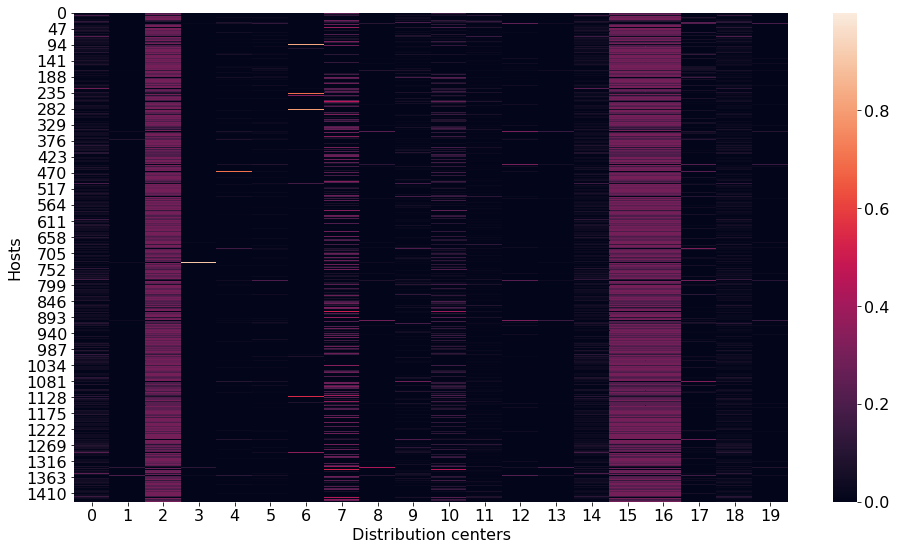

In [9]:
# HOST and clusters
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 16, 9
rcParams['font.size'] = 16

heatmap_hosts = np.zeros(shape=(len(hosts), onlineEM.m))

for i, host in enumerate(hosts):
    heatmap_hosts[i] = onlineEM.hosts[host]['group']
    
ax = sns.heatmap(heatmap_hosts)
plt.ylabel('Hosts')
plt.xlabel('Distribution centers')
plt.show()

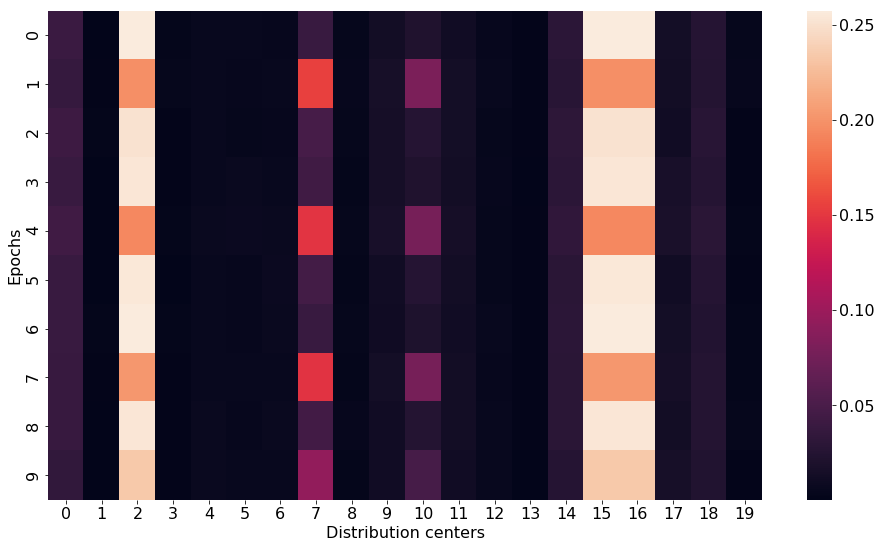

In [10]:
heatmap_epochs = np.zeros(shape=(total_epochs, onlineEM.m))

for i in range(total_epochs):
    df = df_all[(df_all.index > i * time_epoch) & (df_all.index <= (i + 1) * time_epoch)]
    groupped_data_epoch, _ = group_scale_data_batch(df, parameters)
    data = groupped_data_epoch.values[:,[0,1,3]]
    
    f = onlineEM.calculate_participation(data)

    temp_sum = f.sum(axis=0)
    
    heatmap_epochs[i] = temp_sum / sum(temp_sum)
    
    
ax = sns.heatmap(heatmap_epochs)
plt.ylabel('Εpochs')
plt.xlabel('Distribution centers')
plt.show()

In [11]:
onlineEM.gammas

array([ 0.03840484,  0.00134049,  0.23649111,  0.002071  ,  0.00567237,
        0.00532205,  0.00638095,  0.08090011,  0.0031973 ,  0.01342908,
        0.04256371,  0.01454433,  0.00482434,  0.00151437,  0.02900322,
        0.23649111,  0.23649111,  0.01336688,  0.02529407,  0.00269756])

In [12]:
onlineEM.lambdas

array([[13.426996028426919, 44.92173163425974],
       [66.93249277937547, 40.20230349715586],
       [1.0, 1.0],
       [58.63302636906327, 67.0735924205592],
       [34.6087555947756, 34.90594803208331],
       [31.890720818384292, 43.62774638838832],
       [16.041556337688025, 72.51938173059821],
       [13.130930041141633, 24.987182679615408],
       [53.75035141106285, 48.84215195347306],
       [20.86031927170626, 41.50242278118862],
       [14.132793321617505, 25.115363386740153],
       [13.883875495527327, 35.99287036161768],
       [43.54576958091395, 44.579919552501316],
       [54.578231890341875, 46.201356396367345],
       [13.378066353162424, 45.33900069794011],
       [1.0, 1.0],
       [1.0, 1.0],
       [31.510021046643292, 39.54450032593398],
       [14.75342141732041, 43.015407183657764],
       [46.15477101245646, 51.2880451957684]], dtype=object)